# Environments

Coba environments are used to train and evaluate learners. An **Environment** is any class with the following interface:

```python
class Environment:
    def read(self)->Iterable[Interaction]:
        ...
```

where **[Interaction](Interactions.ipynb)** is a Python `dict` with specific entires. Most commonly it is, 
`{'context':..., 'actions':..., 'rewards':...}`.


# Environments API

The **Environments** API creates and manipulates environments via chains of commands. It is accessed via

```python
import coba as cb
cb.Environments
```

There are two types of **Environments** commands. Those that start with `from_` and those that don't.

Every Environments chain starts with a `from_` method. After this any number of filters can be called to modify the environment.

Here is an example
```python
import coba as cb
env = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5))
```

This Environments chain will download the Covertype dataset from openml, create an environment from the dataset, use reservoir sampling to select  1000 random examples from the dataset, apply standardization to all context features in the dataset, and then add gaussian noise to all reward values. A full list of the chain commands can be found [here](Filters.ipynb).

A few more useful details about Environments chains:
+ All Environments chains are Python sequences so they must be indexed to access its contained environment. For example,
```python
import coba as cb
env              = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5))
env_interactions = list(env[0].read()) #Because cb.Environments always creates a Python sequence we have to index
```

+ All Environments chains are seeded so that the same environment will always be recreated. This means..
```python
env1 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5),seed=1)
env2 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5),seed=1)

assert list(env1[0].read()) == list(env2[0].read())
```

+ Environment chains can be added together to get a collection of several environments...
```python
import coba as cb
env1 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5),seed=1)
env2 = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5),seed=2)

env = env1+env2

assert len(env) == 2
assert env[0] is env1
assert env[1] is env2
```

+ Many commands on Environment chains take sequences of values and create multiple environments. For example we can...
```python
env = cb.Environments.from_openml(180).reservoir(1000).scale('mean','std').noise(reward=('g',0,.5),seed=[1,2])

assert len(env) == 2
```

+ The complete list of Environments chain commands can be found [here](...).


# Environment Creation

Coba has many ways to create environments. The five most common are:

1. From a custom class implementing the Environment interface
2. From an openml.org dataset or task
3. From a local dataset
3. From a synthetic dataset
4. From a result file
5. From a template file

## Environments From Custom Classes

The easiest way to create an environment for simple testing is by creating a custom class. Here are two examples.

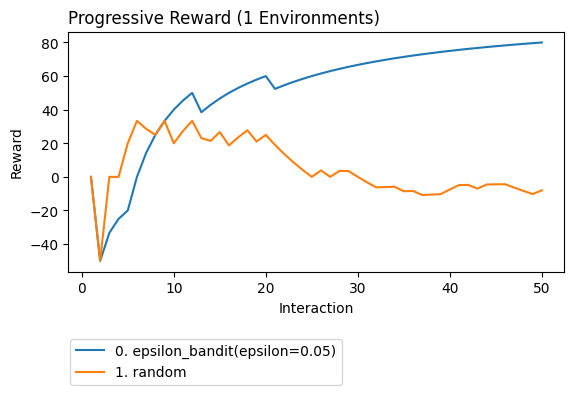

In [18]:
import coba as cb

class BanditEnvironment:    
    def read(self):
        return [ { 'actions':['a','b','c'], 'rewards':[0,100,-100] } ] * 50

environments = cb.Environments.from_custom(BanditEnvironment())
learners     = [cb.EpsilonBanditLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()

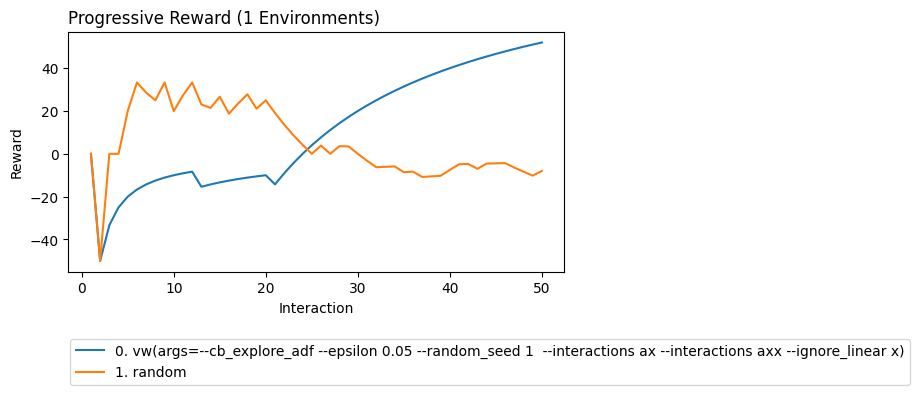

In [17]:
import coba as cb

class ContextualBanditEnvironment:    
    def read(self):
        return [ { 'context':1, 'actions':['a','b','c'], 'rewards':[0,100,-100] } ] * 50

environments = cb.Environments.from_custom(ContextualBanditEnvironment())
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()

## Environments From Openml Datasets

Next we can incorporate new Environments by loading them from openml.org. Openml is is an online repository of machine learning data sets which currently hosts over 21,000 datasets. Using either dataset ids or task ids Coba can tap into this repository and download these datasets to create Environments.

To get a sense of how this works let's say we want to build an environment from the Covertype data set. We can [do a dataset search](https://www.openml.org/search?type=data) on openml to see if this data set is hosted. This search finds several datasets and we pick [the one that appears to be original](https://www.openml.org/d/180). On the dataset's landing page we see that its id is 180. Now, all we have to do to run an experiment with the Covertype data set is:


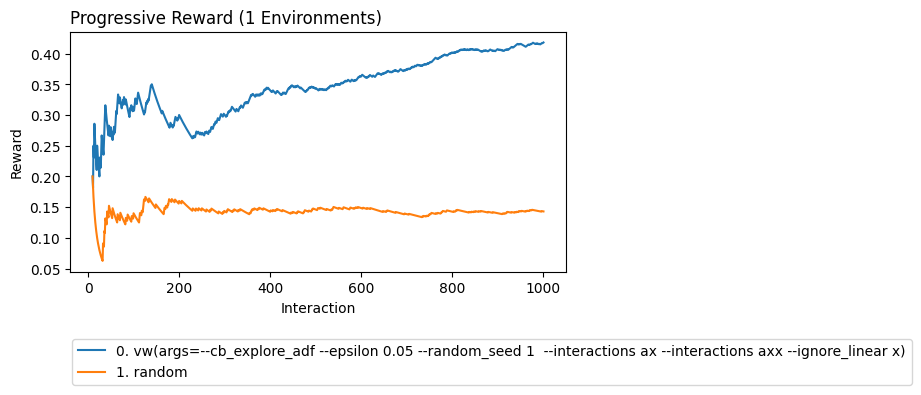

In [4]:
import coba as cb

environments = cb.Environments.from_openml(180).reservoir(1000)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(xlim=(10,None))

## Environments From Local Datasets

Next we can incorporate new environments from local datasets. Coba has built-in support for the following formats:
* CSV
* ARFF (i.e., https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/)
* Libsvm (e.g., https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html)
* Manik (e.g., http://manikvarma.org/downloads/XC/XMLRepository.html)

For example, we may have the iris dataset saved in `iris.arff` in the arff format. To create an environment from this dataset we can.

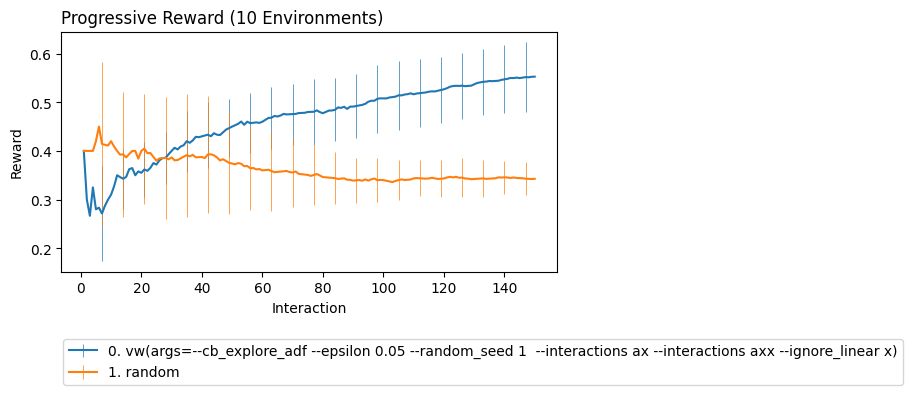

In [6]:
import coba as cb

environments = cb.Environments.from_supervised(cb.ArffSource("iris.arff"), label_col='Species').shuffle(n=10)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')

## Environments From Synthetic Datasets

Coba provides access to several synthetic data generators from many function class families. Coba has built-in support for the following formats:
* Linear
* Nearest Neighbors
* Kernel Methods
* Multilayer Perceptrons

For example, below we create a synthetic dataset whose expected reward function is linear with respect to action features:

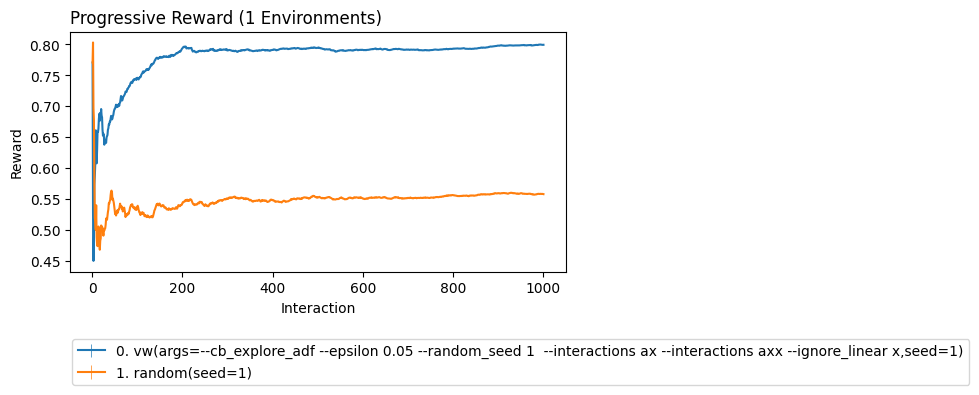

In [2]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(
    n_interactions=1000,
    n_actions=5,
    n_context_features=0,
    n_action_features=5,
    reward_features = ["a"],
    seed=1
)

learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')

## Environments From Result Files

A more advanced use case is to create environments from the result of previous experiments. This is useful for off-policy experiments.

We give an example below, but this topic is covered in much more detail in the [Logged](./Logged.ipynb) notebook.

 ------------------------------------------------------------------------------
 Create the result file with logged actions and plot the on-policy performance.
 ------------------------------------------------------------------------------


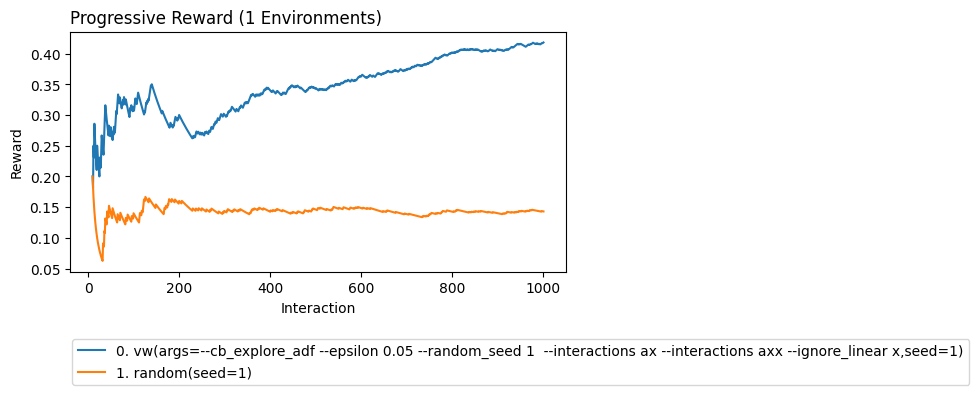

 ------------------------------------------------------------------------------
 Use the result file to create logged bandit data and plot off-policy learning.
 ------------------------------------------------------------------------------


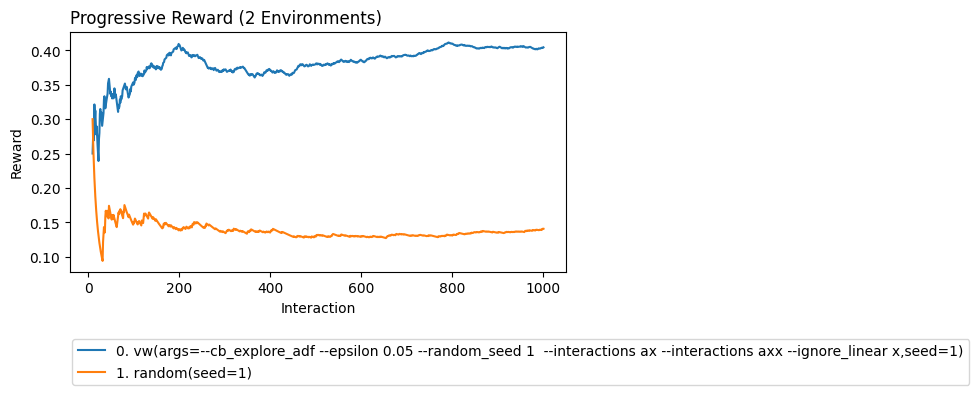

In [5]:
import coba as cb

print(" ------------------------------------------------------------------------------")
print(" Create the result file with logged actions and plot the on-policy performance.")
print(" ------------------------------------------------------------------------------")
environments = cb.Environments.from_openml(180).reservoir(1000)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners, cb.SequentialCB(record=['context','actions','rewards','action','reward','probability']))
experiment.run('result.log', quiet=True).plot_learners(xlim=(10,None))

print(" ------------------------------------------------------------------------------")
print(" Use the result file to create logged bandit data and plot off-policy learning.")
print(" ------------------------------------------------------------------------------")
environments = cb.Environments.from_result('result.log').shuffle(seed=1)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners, cb.SequentialCB(learn='off'))
experiment.run(quiet=True).plot_learners(xlim=(10,None))

## Environments From Template Files

A final very advanced use case is to create environments from file templates.

This is useful when multiple researchers want to compare overall performance on the same set of environments.

By defining Environments in a template file the researchers can be confident their evaluating on the same data.

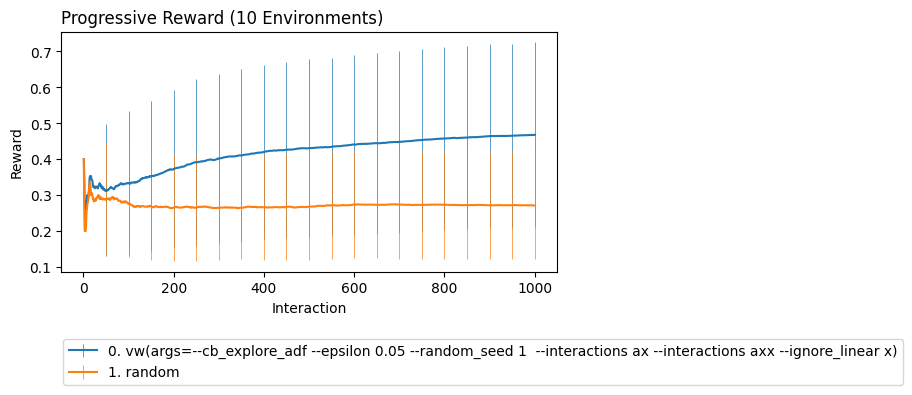

In [48]:
import coba as cb

environments = cb.Environments.from_template('short_experiment.json')
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')